### Test

In [ ]:
import liana as li
from liana.mt import rank_aggregate
import omnipath as op
import decoulper as dc
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
matplotlib.use('Qt5Agg ')
import seaborn as sns

sns.set_theme(font="Arial", font_scale=1, style='ticks')
sc.settings.verbosity = 3
plt.rcParams['figure.figsize'] = (6,6)
plt.rcParams['figure.dpi'] = 100
plt.rc("axes.spines", top=False, right=False)

# ipython에서 %matplotlib 으로 TkAgg로 바꾸면 Freezing됨.

cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["#104e8b", "#ffdab9", "#8b0a50"])
batch_palette=['#689aff', '#fdbf6f', '#b15928']

# import all individual methods
from liana.method import singlecellsignalr, connectome, cellphonedb, natmi, logfc, cellchat, geometric_mean

##### Useful arguments

In [ ]:
li.mt.show_methods()
rank_aggregate.describe()
li.resource.show_resources()
['baccin2019',
 'cellcall',
 'cellchatdb',
 'cellinker',
 'cellphonedb',
 'celltalkdb',
 'connectomedb2020',
 'consensus',
 'embrace',
 'guide2pharma',
 'hpmr',
 'icellnet',
 'italk',
 'kirouac2010',
 'lrdb',
 'mouseconsensus',
 'ramilowski2015']

### Preprocessing of whole cell populations

In [ ]:
test3 = sc.read_h5ad("/data/Projects/phenomata/01.Projects/11.Vascular_Aging/03.Scanpy/test3.h5ad")
test3.obs['Age'] = test3.obs['batch']
# test3.raw.X 는 log1p transformed scran normalized values

leiden_to_celltype_dict = {'0': 'Vascular smooth muscle cells',
'1': 'Vascular smooth muscle cells',
'2': 'Vascular smooth muscle cells',
'3': 'Fibroblasts',
'4': 'Vascular smooth muscle cells',
'5': 'Endothelial cells',
'6': 'Fibroblasts',
'7': 'Endothelial cells',
'8': 'Vascular smooth muscle cells',
'9': 'Fibroblasts',
'10': 'B cells',
'11': 'M\u03A6',
'12': 'T cells',
'13': 'Neuronal cells'}
test3.obs['celltype'] = test3.obs['leiden_r05'].map(lambda x: leiden_to_celltype_dict[x]).astype('category')

lin = ('Endothelial cells', 'Vascular smooth muscle cells', 'Fibroblasts', 'B cells', 'M\u03A6', 'T cells', 'Neuronal cells')
test3.obs['Annotated Cell Types'] = test3.obs['celltype'].cat.reorder_categories(list(lin), ordered=True)

celltype_abbrev = {'Endothelial cells': 'EC',
                   'Vascular smooth muscle cells': 'vSMC',
                   'Fibroblasts': 'FB',
                   'B cells': 'Bc',
                   'M\u03A6': 'M\u03A6',
                   'T cells': 'Tc',
                   'Neuronal cells': 'Neu'
                   }
test3.obs['celltype_abbrev'] = test3.obs['Annotated Cell Types'].map(lambda x: celltype_abbrev[x]).astype('category')
test3.obs['Age_Celltype_Combined'] = test3.obs.apply(lambda x: f"{x['Age']}_{x['celltype_abbrev']}", axis=1)
test3.obs['Age_Celltype_Combined'] = test3.obs['Age_Celltype_Combined'].astype('category')

age_celltype_order = ("m01_vSMC", "m10_vSMC", "m20_vSMC", "m01_FB", "m10_FB", "m20_FB", "m01_EC", "m10_EC", "m20_EC", "m01_Bc", "m10_Bc", "m20_Bc", "m01_MΦ", "m10_MΦ", "m20_MΦ", "m01_Tc", "m10_Tc", "m20_Tc", "m01_Neu", "m10_Neu", "m20_Neu")
test3.obs['Age_Celltype_Combined'] = test3.obs['Age_Celltype_Combined'].cat.reorder_categories(list(age_celltype_order), ordered=True)

celltype_colormap = {'Endothelial cells': '#393b79',
                     'Vascular smooth muscle cells': '#9c9ede',
                     'Fibroblasts': '#b5cf6b',
                     'B cells': '#e7ba52',
                     'M\u03A6': '#ad494a',
                     'T cells': '#7b4173',
                     'Neuronal cells': '#de9ed6'} #palette = 'tab20b'
celltype_abbrev_colormap = {'EC': '#393b79',
                            'vSMC': '#9c9ede',
                            'FBs': '#b5cf6b',
                            'Bc': '#e7ba52',
                            'M\u03A6': '#ad494a',
                            'Tc': '#7b4173',
                            'Neu': '#de9ed6'} #palette = 'tab20b'

leiden_to_detailed_celltype_dict = {'0': 'vSMC1',
                                    '1': 'vSMC2',
                                    '2': 'vSMC3',
                                    '3': 'FB1',
                                    '4': 'vSMC4',
                                    '5': 'EC1',
                                    '6': 'FB2',
                                    '7': 'EC2',
                                    '8': 'vSMC5',
                                    '9': 'FB3',
                                    '10': 'Bc',
                                    '11': 'M\u03A6',
                                    '12': 'Tc',
                                    '13': 'Neu'}
test3.obs['detailed_celltype'] = test3.obs['leiden_r05'].map(lambda x: leiden_to_detailed_celltype_dict[x]).astype('category')
detailed_celltype_order = ('EC1', 'EC2', 'vSMC1', 'vSMC2', 'vSMC3', 'vSMC4', 'vSMC5', 'FB1', 'FB2', 'FB3', 'Bc', 'M\u03A6', 'Tc', 'Neu')
test3.obs['detailed_celltype'] = test3.obs['detailed_celltype'].cat.reorder_categories(list(detailed_celltype_order), ordered=True)

test3.obs['Age_detailed_Celltype_Combined'] = test3.obs.apply(lambda x: f"{x['Age']}_{x['detailed_celltype']}", axis=1)
test3.obs['Age_detailed_Celltype_Combined'] = test3.obs['Age_detailed_Celltype_Combined'].astype('category')

detailed_celltype_colormap = {'EC1': '#393b79', 
                              'EC2': '#5254a3', 
                              'vSMC1': '#9c9ede', 
                              'vSMC2': '#637939', 
                              'vSMC3': '#b5cf6b', 
                              'vSMC4': '#cedb9c', 
                              'vSMC5': '#bd9e39', 
                              'FB1': '#e7ba52', 
                              'FB2': '#843c39', 
                              'FB3': '#ad494a', 
                              'Bc': '#e7969c', 
                              'MΦ': '#7b4173', 
                              'Tc': '#ce6dbd', 
                              'Neu': '#de9ed6'} #palette = 'tab20b'

rand_is = np.random.permutation(list(range(test3.shape[0])))
#sc.pl.umap(test3[rand_is,:], add_outline=False, legend_loc='on data', size=30, legend_fontsize=8, legend_fontoutline=1, color_map=cmap, color=['Mif'])

### Starting from whole cells with GRN data

In [ ]:
test3 = sc.read_h5ad("/data/Projects/phenomata/01.Projects/11.Vascular_Aging/03.Scanpy/pySCENIC/ALL/test3_pyscenic.h5ad")

### Breaking whole cells into three parts based on age groups

In [ ]:
test3_m01 = test3[test3.obs['Age'] == 'm01'].copy()
test3_m10 = test3[test3.obs['Age'] == 'm10'].copy()
test3_m20 = test3[test3.obs['Age'] == 'm20'].copy()

### Cell-cell communications analysis

In [ ]:
# For CellPhoneDB
## For Cell types
cellphonedb(test3, groupby='celltype', expr_prop=0.25, min_cells=5, resource_name='mouseconsensus', verbose=True, key_added='cpdb_celltype_res')
test3.uns['cpdb_celltype_res']

## For Age+Detailed Cell types
cellphonedb(test3, groupby='Age_detailed_Celltype_Combined', expr_prop=0.25, min_cells=5, resource_name='mouseconsensus', verbose=True, key_added='cpdb_age-detailed-celltype_res')

'''From https://www.sc-best-practices.org/mechanisms/cell_cell_communication.html
source and target columns represent the source/sender and target/receiver cell identity for each interaction, respectively

*_props: represents the proportion of cells that express the entity.

By default, in CellPhoneDB and LIANA, any interactions in which either entity is not expressed in above 10% of cells per cell type is considered as a false positive, under the assumption that since CCC occurs between cell types, a sufficient proportion of cells within should express the genes.

*_means: entity expression mean per cell type

lr_means: mean ligand-receptor expression, as a measure of ligand-receptor interaction magnitude

cellphone_pvals: permutation-based p-values, as a measure of interaction specificity'''

test3.uns['cpdb_age-detailed-celltype_res'][['ligand', 'ligand_means', 'ligand_props', 'receptor', 'receptor_means', 'receptor_props', 'source', 'target', 'lr_means', 'cellphone_pvals']]

# Perform CellphoneDB separately for different age groups
cellphonedb(test3_m01, groupby='detailed_celltype', expr_prop=0.25, min_cells=5, resource_name='mouseconsensus', verbose=True, key_added='cpdb_detailed_celltype_res')
cellphonedb(test3_m10, groupby='detailed_celltype', expr_prop=0.25, min_cells=5, resource_name='mouseconsensus', verbose=True, key_added='cpdb_detailed_celltype_res')
cellphonedb(test3_m20, groupby='detailed_celltype', expr_prop=0.25, min_cells=5, resource_name='mouseconsensus', verbose=True, key_added='cpdb_detailed_celltype_res')

test3_m01.uns['cpdb_detailed_celltype_res'][['ligand', 'ligand_means', 'ligand_props', 'receptor', 'receptor_means', 'receptor_props', 'source', 'target', 'lr_means', 'cellphone_pvals']]
test3_m10.uns['cpdb_detailed_celltype_res'][['ligand', 'ligand_means', 'ligand_props', 'receptor', 'receptor_means', 'receptor_props', 'source', 'target', 'lr_means', 'cellphone_pvals']]
test3_m20.uns['cpdb_detailed_celltype_res'][['ligand', 'ligand_means', 'ligand_props', 'receptor', 'receptor_means', 'receptor_props', 'source', 'target', 'lr_means', 'cellphone_pvals']]


test3_m20.uns['cpdb_detailed_celltype_res'][(test3_m20.uns['cpdb_detailed_celltype_res']['source'] == 'EC2') | (test3_m20.uns['cpdb_detailed_celltype_res']['target'] == 'EC2')][['ligand', 'ligand_means', 'ligand_props', 'receptor', 'receptor_means', 'receptor_props', 'source', 'target', 'lr_means', 'cellphone_pvals']].sort_values(by='cellphone_pvals').head(n=30)

### on MacOS (scCODA)

In [42]:
import scanpy as sc
import pandas as pd
from sccoda.util import cell_composition_data as dat
from sccoda.util import data_visualization as viz
import anndata

In [4]:
import os;os.getcwd()

'/Users/mhryansohn/Desktop/01.Workspace/01.Projects/01.Vascular_Aging/github_vAging/vAging/05.Liana-py'

In [54]:
test3 = sc.read_h5ad("/Users/mhryansohn/Desktop/01.Workspace/01.Projects/01.Vascular_Aging/test3.h5ad")
test3.obs['Age'] = test3.obs['batch']
leiden_to_detailed_celltype_dict = {'0': 'vSMC1',
                                    '1': 'vSMC2',
                                    '2': 'vSMC3',
                                    '3': 'FB1',
                                    '4': 'vSMC4',
                                    '5': 'EC1',
                                    '6': 'FB2',
                                    '7': 'EC2',
                                    '8': 'vSMC5',
                                    '9': 'FB3',
                                    '10': 'Bc',
                                    '11': 'M\u03A6',
                                    '12': 'Tc',
                                    '13': 'Neu'}
test3.obs['detailed_celltype'] = test3.obs['leiden_r05'].map(lambda x: leiden_to_detailed_celltype_dict[x]).astype('category')

In [53]:
test3_m01 = test3[test3.obs['Age'] == 'm01'].copy()
test3_m10 = test3[test3.obs['Age'] == 'm10'].copy()
test3_m20 = test3[test3.obs['Age'] == 'm20'].copy()
test3_concat = anndata.concat([test3_m01, test3_m10, test3_m20])

In [59]:
cov_df = pd.DataFrame({"Group": ["Young", "Middle_Aged", "Old"]}, index=['m01', 'm10', 'm20'])
cov_df

,Group
m01,Young
m10,Middle_Aged
m20,Old


In [60]:
data_test3 = dat.from_scanpy(
    test3_concat,
    cell_type_identifier='detailed_celltype',
    sample_identifier='Age',
    covariate_df=cov_df
)

In [68]:
data_test3.obs

,Group
Age,
m01,Young
m10,Middle_Aged
m20,Old


KeyError: 'Age'

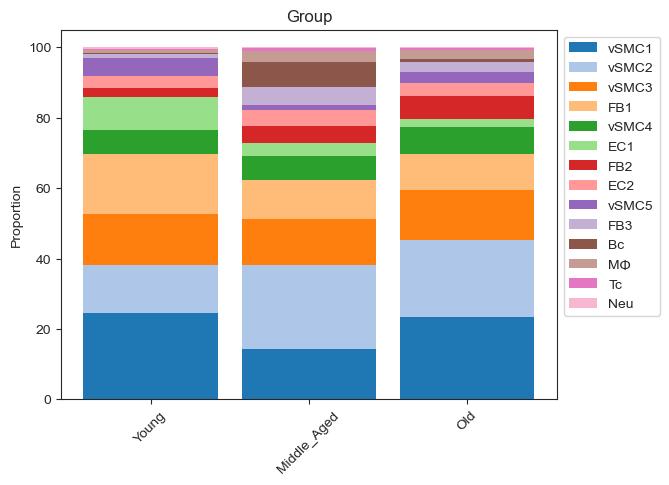

In [67]:
data_test3.var
viz.stacked_barplot(data_test3, feature_name="Group")
viz.stacked_barplot(data_test3, feature_name="Age")